In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# necessary imports
!pip install xmltodict
import os
import tarfile
import xmltodict
import pandas as pd
import xml.etree.ElementTree as ET

In [ ]:
# extracting the xml records
folder_path = "drive/MyDrive/BAIS6100/Datasets/Project3_data"

# List all XML files in the folder
xml_files = [f for f in os.listdir(folder_path) if f.endswith('.xml')]

# Iterate through each XML file and save the text portion to a dataframe
data_list = []

for file_name in xml_files:
    file_path = os.path.join(folder_path, file_name)

    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract 'TEXT' data
    text_element = root.find('TEXT')
    text_data = text_element.text if text_element is not None else "No TEXT found"

    data_list.append({'File Name': file_name, 'Text': text_data})

df = pd.DataFrame(data_list)

In [ ]:
# Separate the dataframe into three columns, one for patientID (first part of file name), one for visit number (second part of file name), and one for the text
df[['patientID', 'visit']] = df['File Name'].str.split("-", n=1, expand=True)

# Further split 'visit' into 'visit' and 'x' using "."
df[['visit', 'x']] = df['visit'].str.split(".", n=1, expand=True)
'
df = df.rename(columns={'Text': 'text'})

# Select relevant columns and sort by 'patientID'
df = df[['patientID', 'visit', 'text']].sort_values(by=['patientID', 'visit'])

In [ ]:
print(df.iloc[10, 2]) # view the text portion of the 10th record (example usage)




Record date: 2124-09-28

			

NPH 20

Lopressor 75 mg tid	795-76-17

Lisinopril 10 mg qd	CORONA, Bruce

ASA 325 mg qd	

Flomax 0.4 mg bid

Celebrex 100 mg qd

Colace 100 mg bid



September 28, 2124



Interim History:	

Comes to review diabetes and related problems.

He had L THR in April

Has gained some weight since the surgery.

However, he reports that his BS are erratic despite a good diet and good appetite. He has had some symptoms of hypoglycemia in the late morning. He has checked his BS at that time and has found BS in the 70's-90's. 

Home Blood Tests:  

B 	87-140's, and occasionally in the 200's, which he attributes to    bad food    the previous evening. 

Retinopathy:	He has seen Dr. Dailey within a month or so. Again going next week. He has had a Bell's palsy by report. It has improved very significant ly. 

Nephropathy:	Due for microalbumin/creatinine ratio; normal in past.

Neuropathy:	No foot discomfort.

Cardiac:	No chest pain. No unusual dyspnea on exertion thou

In [ ]:
# number of records
print(len(df))

1303


In [ ]:
# number of patients
print(len(df.groupby('patientID')))

296


# Blood Pressure

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract systolic and diastolic blood pressure using regex
df[['systole', 'diastole']] = df['text'].str.extract(r'(\d{2,3})\s*/\s*(\d{2,3})')

# Convert extracted values to numeric
df[['systole', 'diastole']] = df[['systole', 'diastole']].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
df = df.dropna(subset=['systole', 'diastole'])

# Categorize blood pressure levels
def classify_bp(systole, diastole):
    if systole > 180 or diastole > 120:
        return "Crisis"
    elif systole >= 140 or diastole >= 90:
        return "Hypertension 2"
    elif 130 <= systole <= 139 or 80 <= diastole <= 89:
        return "Hypertension 1"
    elif 120 <= systole <= 129 and diastole < 80:
        return "Elevated"
    elif systole < 120 and diastole < 80:
        return "Normal"
    return "Unknown"

df.loc[:, 'level'] = df.apply(lambda row: classify_bp(row['systole'], row['diastole']), axis=1)

# Remove "Unknown" values
df = df[df['level'] != "Unknown"]



<ipython-input-10-b880c9c973e0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'level'] = df.apply(lambda row: classify_bp(row['systole'], row['diastole']), axis=1)


In [ ]:
print(df.head)

<bound method NDFrame.head of      patientID visit                                               text  \
250        100    01  \n\n\nRecord date: 2106-02-12\n\nCampbell Orth...   
431        100    02  \n\n\nRecord date: 2108-03-14\n\n             ...   
246        100    03  \n\n\nRecord date: 2109-09-14\n\n \nSeptember ...   
482        100    04  \n\n\nRecord date: 2111-10-10\n\n    \n\n\n\nC...   
244        100    05  \n\n\nRecord date: 2111-12-14\n\n \n\n\n\nNEUR...   
...        ...   ...                                                ...   
19         400    01  \n\n\nRecord date: 2062-06-10\n\nMedical Walk ...   
126        400    02  \n\n\nRecord date: 2062-07-21\n\n\n\nHalcyon H...   
190        400    03  \n\n\nRecord date: 2066-10-14\n\nHPI; pt was s...   
1113       400    04  \n\n\nRecord date: 2067-03-13\n\nHistory of Pr...   
49         400    05  \n\n\nRecord date: 2067-04-14\n\n\n\n\n\n\n\n\...   

      systole  diastole   level level_fct  
250       2.0      12.0  

In [ ]:
# save to csv
#df.to_csv('drive/MyDrive/BAIS6100/project_df.csv', index=False)

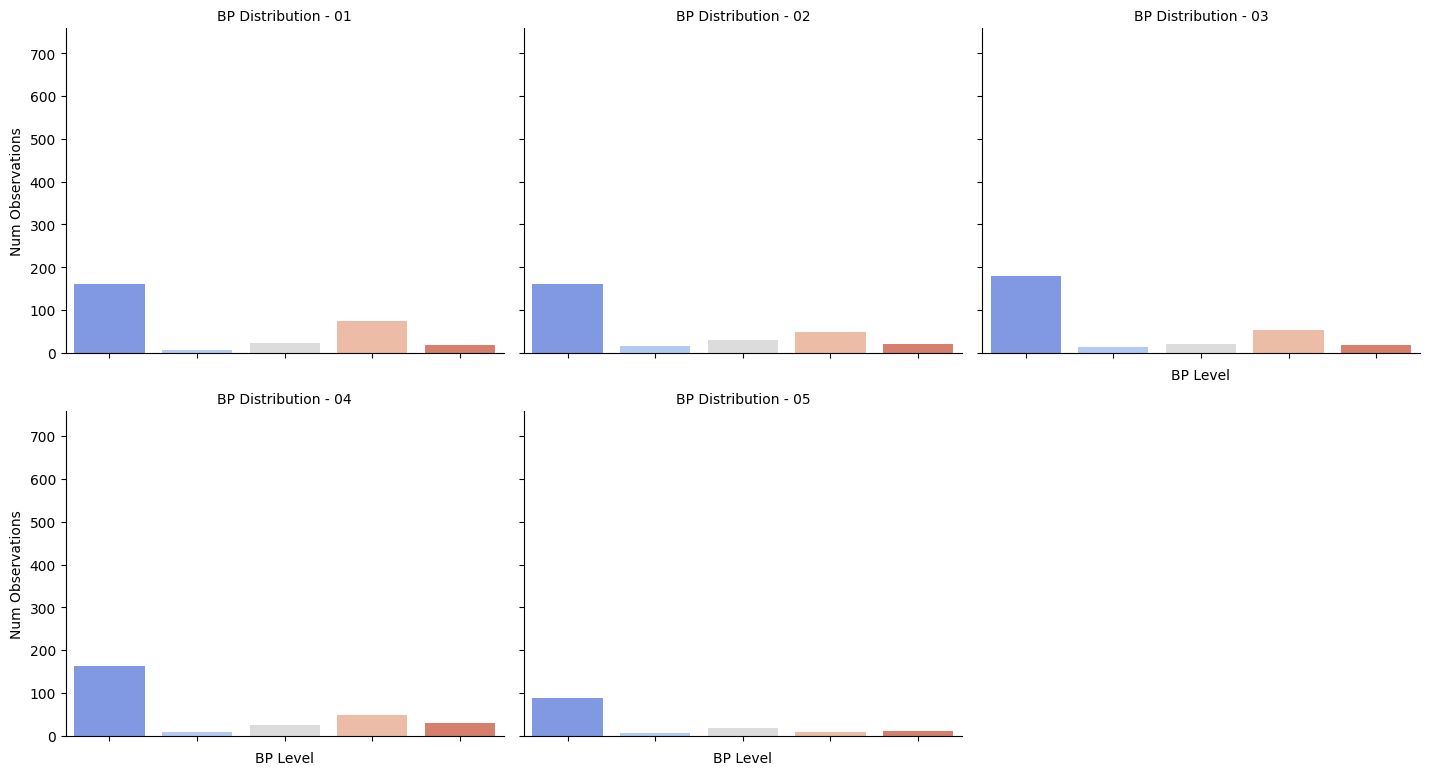

In [ ]:
# plot counts of each blood pressure level, faceted by visit number
import seaborn as sns
import matplotlib.pyplot as plt

# Create factor for BP levels
bp_levels = ["Normal", "Elevated", "Hypertension 1", "Hypertension 2", "Crisis"]
df['level_fct'] = pd.Categorical(df['level'], categories=bp_levels, ordered=True)

# Same for visits
visit_labels = ["Visit 1", "Visit 2", "Visit 3", "Visit 4", "Visit 5"]
df['visit_fct'] = pd.Categorical(df['visit'], categories=["01", "02", "03", "04", "05"], ordered=True)

# Faceted bar plot by visit number
g = sns.catplot(
    data=df,
    x="level_fct",
    hue="level_fct",
    col="visit_fct",  # Facet by visit
    kind="count",
    palette="coolwarm",
    order=bp_levels,
    col_wrap=3,
    height=4,
    aspect=1.2
)

g.set_titles("BP Distribution - {col_name}")
g.set_axis_labels("BP Level", "Num Observations")
g.set_xticklabels(rotation=45)
g.set(ylim=(0, df['level_fct'].value_counts().max() + 5))
plt.show()





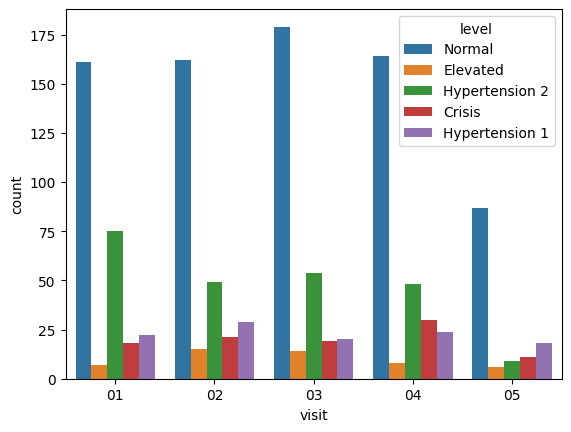

In [ ]:
# or
sns.countplot(data=df, x="visit", hue="level")
plt.show()

# Social History

In [ ]:
import pandas as pd
import re

def extract_social_history(text):
    # Find start index
    if re.search(r'(?i)social history', text):
        soc_startin = re.search(r'(?i)social history', text).start() + 15
    elif 'SH' in text:
        soc_startin = text.find('SH') + 3
    else:
        return None  # No recognizable start

    rest_of_text = text[soc_startin:]

    # Find end index: look for "\n\n\n"
    match = re.search(r'\n\n\n', rest_of_text)
    if match:
        soc_endin = match.start()
        soc_history = text[soc_startin:soc_startin + soc_endin]
    else:
        soc_history = text[soc_startin:soc_startin + 200]  # Default to 200 characters

    return soc_history

# Apply
df['soc_history'] = df['text'].apply(extract_social_history)

# Has social history by record
df['has_history'] = df['soc_history'].notna()

# Has social history by patient
num_patients_with_history = df[df['has_history']]['patientID'].nunique()

# Combine social history per patient for topic modeling
combined_hist = (
    df[df['has_history']]
    .groupby('patientID')['soc_history']
    .apply(lambda texts: ' '.join(texts))
    .reset_index()
    .rename(columns={'soc_history': 'history'})
)


In [ ]:
df

,patientID,visit,text,systole,diastole,level,level_fct,visit_fct,soc_history,has_history
250,100,01,\n\n\nRecord date: 2106-02-12\n\nCampbell Orth...,2.0,12.0,Normal,Normal,01,None,False
431,100,02,\n\n\nRecord date: 2108-03-14\n\n ...,3.0,14.0,Normal,Normal,02,AND FAMILY HISTORY: As indicated in the chart...,True
246,100,03,\n\n\nRecord date: 2109-09-14\n\n \nSeptember ...,11.0,9.0,Normal,Normal,03,The patient denies active tobacco or alcoholi...,True
482,100,04,\n\n\nRecord date: 2111-10-10\n\n \n\n\n\nC...,10.0,10.0,Normal,Normal,04,"No EtOH, no tob, no illicits",True
244,100,05,\n\n\nRecord date: 2111-12-14\n\n \n\n\n\nNEUR...,12.0,13.0,Normal,Normal,05,\tTob:\toccas cigar\tEtOH: 0 (used to have E...,True
...,...,...,...,...,...,...,...,...,...,...
19,400,01,\n\n\nRecord date: 2062-06-10\n\nMedical Walk ...,190.0,116.0,Crisis,Crisis,01,None,False
126,400,02,\n\n\nRecord date: 2062-07-21\n\n\n\nHalcyon H...,7.0,21.0,Normal,Normal,02,,True
190,400,03,\n\n\nRecord date: 2066-10-14\n\nHPI; pt was s...,188.0,100.0,Crisis,Crisis,03,None,False
1113,400,04,\n\n\nRecord date: 2067-03-13\n\nHistory of Pr...,21.0,67.0,Normal,Normal,04,None,False


In [ ]:
combined_hist

,patientID,history
0,100,AND FAMILY HISTORY: As indicated in the chart...
1,101,is 2.0. LFTs are pending at this time. We \n...
2,102,\n\nSmoking: no\n\nAlcohol use: no history of ...
3,103,AND FAMILY HISTORY: Remote history of smoking...
4,104,A MEMORIAL HOSPITAL Lives in Pooler with boyf...
...,...,...
275,396,One pack per day smoker and does not drink. ...
276,397,\n\nSingle. Divorced. He has 1 child - he do...
277,398,: Retired. No kids. Lives in 90 Yvonne St V...
278,399,":\tpositive for smoking, occasional ethanol"


# Topic Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download("stopwords")
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
  def build_analyzer(self):
    analyzer = super(StemmedCountVectorizer, self).build_analyzer()
    return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Choose # of Topics

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(combined_hist, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
global_stopwords = nltk.corpus.stopwords.words("english")

vectorizer = StemmedCountVectorizer(stop_words=global_stopwords,
                                    max_features=100)
train_x = vectorizer.fit_transform(df_train["history"])
test_x = vectorizer.transform(df_test["history"])

2
3
4
5
6
7
8
9
10


Text(0, 0.5, 'Perplexity')

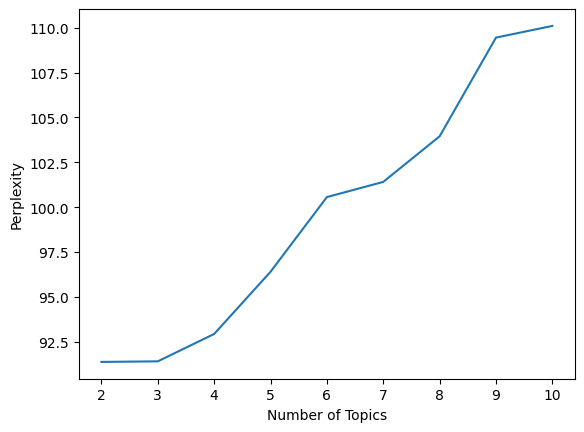

In [ ]:
lda = LatentDirichletAllocation(n_jobs=-1,
                                random_state=6100)
num_topics = [2, 3, 4, 5, 6, 7, 8, 9, 10]
perplexity = []
for i in num_topics:
  print(i)
  lda.set_params(n_components=i)
  lda.fit(train_x)
  perplexity.append(lda.perplexity(test_x))

plt.plot(num_topics, perplexity)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")

High perplexity values, doesn't mean much in a vacuum, but could suggest that there is high variance in the social histories.

In [ ]:
# Fit LDA on whole corpus
DTM = vectorizer.fit_transform(combined_hist["history"])
lda = LatentDirichletAllocation(n_components=3,
                                n_jobs=-1,
                                random_state=6100)
lda.fit(DTM)

LatentDirichletAllocation(n_components=3, n_jobs=-1, random_state=6100)

Trying PyLDAvis

In [ ]:
#!pip install pyLDAvis
#!pip install numpy==1.24.4
import pyLDAvis
import pyLDAvis.lda_model

html = pyLDAvis.lda_model.prepare(lda, DTM, vectorizer)

# save html
#pyLDAvis.save_html(html, 'drive/MyDrive/BAIS6100/lda_sklearn.html')

Within-topic and between-topic similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# get document-topic distribution matrix (rows = docs, cols = topics)
doc_topic_dist = lda.transform(DTM)  # shape: (num_docs, num_topics)
print(doc_topic_dist.shape)
# normalize for cosine similarity
doc_topic_dist = normalize(doc_topic_dist, norm='l2')

# Assign each document to its dominant topic
doc_labels = np.argmax(doc_topic_dist, axis=1)

# within-cluster similarities
within_sims = []
for topic_id in range(lda.n_components):
    indices = np.where(doc_labels == topic_id)[0] # get indices for documents assigned to topic i
    cluster_docs = doc_topic_dist[indices] # subset docs according to those indices
    sims = cosine_similarity(cluster_docs) # computes cosine similarity for every pair of documents
    upper_tri = sims[np.triu_indices_from(sims, k=1)] # matrix is necessarily symmetric, so take just the upper triangle
    if len(upper_tri) > 0:
        within_sims.append(np.mean(upper_tri))

avg_within_similarity = np.mean(within_sims)

# between-cluster similarity
topic_centroids = []
for topic_id in range(lda.n_components):
    indices = np.where(doc_labels == topic_id)[0]
    if len(indices) == 0:
        continue
    topic_centroids.append(doc_topic_dist[indices].mean(axis=0))

centroid_sim_matrix = cosine_similarity(topic_centroids)
between_sims = centroid_sim_matrix[np.triu_indices_from(centroid_sim_matrix, k=1)]
avg_between_similarity = np.mean(between_sims)


(280, 3)


In [ ]:
print(within_sims) # within-cluster similarity scores for each topic
print(avg_within_similarity) # average similarity for the three topics
print(between_sims) # average between-cluster simlarity for each topic with the other two
print(avg_between_similarity) # average of the three

[0.9149128582637913, 0.9368806881920287, 0.903882414102648]
0.9185586535194893
[0.35288511 0.41413811 0.3308445 ]
0.365955906252009
